### Twitter Data Analysis


In [1]:
import os
from fnmatch import fnmatch
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import spacy
import glob
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import datetime
import re
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import itertools
import collections

In [2]:
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [3]:
filename=[]
root = '../data/'
pattern = "*.csv"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            filename.append(os.path.join(path, name))

In [4]:
data = pd.concat( [ pd.read_csv(file) for file in filename ] )
data.reset_index(inplace=True)


In [5]:
data.head()

,index,date,tweet,word
0,0,2019-01-20 23:04:24+00:00,Logitech Prodigy G213 Gaming Keyboard [50% dis...,amazonindia
1,1,2019-01-20 22:47:26+00:00,Can you guys (whoever's reading this) dm @/Ama...,amazonindia
2,2,2019-01-20 22:04:27+00:00,Artis E400M in-Ear Headphones with Mic (Black)...,amazonindia
3,3,2019-01-20 21:24:51+00:00,@JeffBezos called Amazon India to report an in...,amazonindia
4,4,2019-01-20 21:04:30+00:00,TP-Link HA100 NFC-Enabled Bluetooth Music Rece...,amazonindia


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45144 entries, 0 to 45143
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   45144 non-null  int64 
 1   date    45144 non-null  object
 2   tweet   45143 non-null  object
 3   word    45144 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [7]:
data['Date'] = [datetime.datetime.fromisoformat(x).date() for x in data['date']]
data.drop(['date','index','word'],axis=1,inplace=True)

In [8]:
data.head()

,tweet,Date
0,Logitech Prodigy G213 Gaming Keyboard [50% dis...,2019-01-20
1,Can you guys (whoever's reading this) dm @/Ama...,2019-01-20
2,Artis E400M in-Ear Headphones with Mic (Black)...,2019-01-20
3,@JeffBezos called Amazon India to report an in...,2019-01-20
4,TP-Link HA100 NFC-Enabled Bluetooth Music Rece...,2019-01-20


In [ ]:
# data['tag']=None
# data['mention']=None
# for i in range(data.shape[0]):
#     try:
#         data['tag'][i] = re.findall(r'(?<=\W)[#]\S*', data['tweet'][i])
#         data['mention'][i] = re.findall(r'(?<=\W)[@]\S*', data['tweet'][i])
        
#     except TypeError:
#         pass

In [ ]:
# data['is_mention'] = None

# for mention in data['mention']:
#     if mention!=None:
#         mention1 = [x.lower() for x in mention]
#         r = re.compile(".*amazon")
#         l = list(filter(r.match, mention1))
#         if len(l)>0:
#             data['is_mention'] = 1
#         else:
#             data['is_mention'] = 0

In [15]:
# Making text lower case
data['tweet'] = [str(x).lower() for x in data['tweet']]

#Removing stop words and punctuation, hyperlinks
# def remove_url(txt):
#     return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

# def form_sentence(tweet):
#     tweet_blob = TextBlob(tweet)
#     return ' '.join(tweet_blob.words)
# data['cleaned_tweets'] = [form_sentence(str(x))  for x in data['tweet']]

data['cleaned_tweet'] = [remove_url(str(x)) for x in data['tweet']]
data['cleaned_tweet'] = [re.sub('[^A-z0-9 # @ %]', '', x) for x in data['cleaned_tweet']]

In [20]:
words_in_tweet = [tweet.lower().split() for tweet in data['cleaned_tweet']]

In [21]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('amazon', 27400),
 ('india', 22851),
 ('#amazonindia', 22397),
 ('the', 15963),
 ('to', 15721),
 ('on', 13696),
 ('and', 12580),
 ('for', 9632),
 ('of', 9359),
 ('i', 9332),
 ('is', 9323),
 ('a', 8646),
 ('with', 7797),
 ('in', 7685),
 ('#amazon', 7187)]

In [22]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,amazon,27400
1,india,22851
2,#amazonindia,22397
3,the,15963
4,to,15721


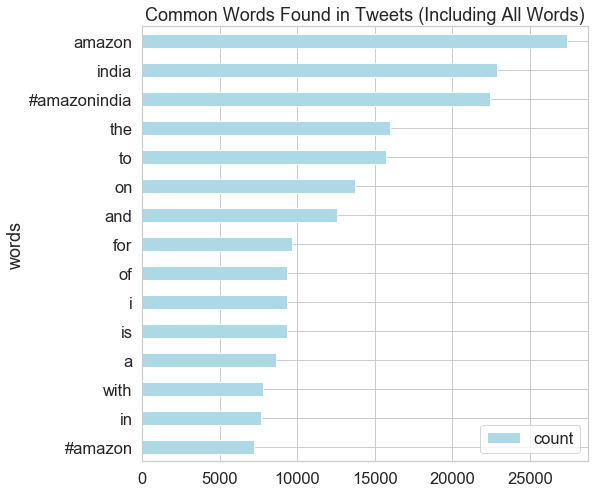

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="lightblue")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

In [24]:
#Removing stopwords
stop_words = set(stopwords.words('english'))

In [25]:
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

In [26]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('amazon', 27400),
 ('india', 22851),
 ('#amazonindia', 22397),
 ('#amazon', 7187),
 ('@amazonin', 5336),
 ('discount]', 3997),
 ('buy', 2819),
 ('#quiztimemorningswithamazon', 2814),
 ('#dealsonelectronics', 2790),
 ('offer', 2700),
 ('order', 2674),
 ('get', 2657),
 ('@amazon', 2510),
 ('customer', 2428),
 ('product', 2363)]

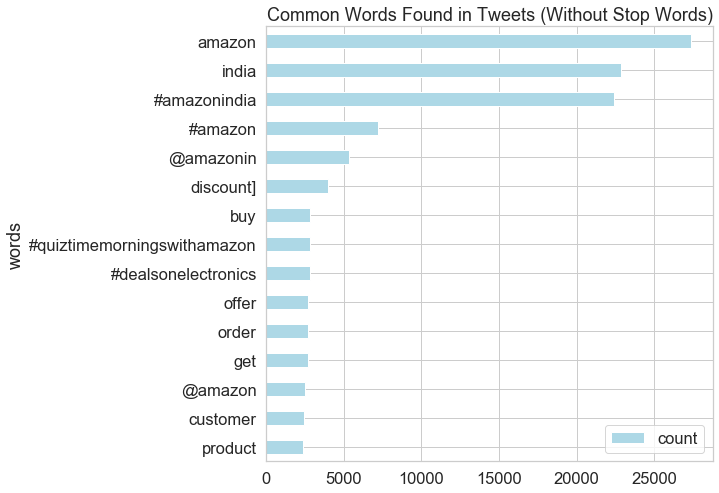

In [27]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="lightblue")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

In [ ]:
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw]

In [ ]:
terms_bigram